In [1]:
%reload_ext autoreload
%autoreload 2 
import numpy as np
import matplotlib.pyplot as plt  

from env import SingleStateSpace 
from env import DoubleStateSpace
from RewardFunctions import SingleStateReward
from RewardFunctions import DoubleStateReward

from policy_walk import PolicyWalk 
from priors import UniformPrior 
from priors import TimeDependentPrior

from generate_trajectory import generate_trajectory
from policy import Boltzmann 
from learn import policy_iteration

import cProfile
import re 

In [56]:
#Set up the environment
#Number of traejectories doesn't have as significant as effect as trajectory_length because this actually affects the size of the reward tensors 
# trajectory_length = 470 #210 for smaller 
env = SingleStateSpace(n_actions = 4, discount_rate = 0.1, R_max = 5)
# env = DoubleStateSpace(n_actions=10, discount_rate = 0.1)

#generate observation times 
# observation_times = np.cumsum(np.random.uniform(0, 2, size=trajectory_length))
# observation_times = np.load('observation_times.npy')
observation_times = np.load('smaller_observation_times.npy')

# Create a matrix for the true rewards 
# s_grid, a_grid, t_grid = np.meshgrid(env.states, env.actions, observation_times, indexing='ij')
# R = np.vectorize(env.reward)(s_grid,a_grid,t_grid)

#Find the optimal policy, values and q_values for the true reward to generate the trajectory. 
alpha = 2
# (optimal_pi, optimal_values, optimal_q_values) = policy_iteration(env,trajectory_length,R)
# b = Boltzmann(optimal_q_values, env.actions, alpha = alpha)

#multiple trajectories are combined - just means that the agent does multiple things at each time slot to allow for more data to be gathered
# observations = generate_trajectory(env,b,observation_times, n_trajectories=50) 
# observations = np.load('observations.npy')
observations = np.load('smaller_observations.npy')
print(observations.shape)
step_size = 0.0035
# step_size = 0.035
prior = TimeDependentPrior(observation_times, R_max = 5, sigma = 0.1)
# prior = UniformPrior(R_max = 5)

pw = PolicyWalk(env,prior,observations,observation_times,alpha)
# cProfile.run('re.compile(pw.get_samples(step_size, n_iters = 1000))')
learned_rewards, acceptance_probs = pw.get_samples(step_size, n_iters = 250000)
# # policy_walk_iters = 1
# # for _ in range(policy_walk_iters-1): 
# #     learned_rewards = np.concatenate((learned_rewards, pw.get_samples(step_size, n_iters = 150000)))

(8303, 3)
1.0% 2.0% 4.0% 5.0% 7.000000000000001% 8.0% 10.0% 13.0% 14.000000000000002% 16.0% 17.0% 20.0% 23.0% 26.0% 27.0% 28.000000000000004% 32.0% 33.0% 34.0% 39.0% 40.0% 45.0% 46.0% 52.0% 53.0% 54.0% 55.00000000000001% 56.00000000000001% 64.0% 65.0% 66.0% 67.0% 68.0% 77.0% 78.0% 79.0% 80.0% 81.0% 90.0% 91.0% 92.0% 93.0% 

In [64]:
# learned_rewards.shape
# #Flatten the rewards 
converged_rewards = learned_rewards[125000]
flattened_rewards = converged_rewards.reshape(converged_rewards.shape[0], -1)
cov = np.cov(flattened_rewards.T)
from statsmodels.stats.correlation_tools import cov_nearest
pd_cov = cov_nearest(cov, threshold = 1e-8)

# zero_mean = np.zeros(flattened_rewards.shape[1])
# test = np.random.normal(np.zeros(flattened_rewards.shape[1]))
# print(pd_cov)
# np.linalg.cholesky(np.load('cov.npy'))
np.save('spotify_short_cov',cov)
# print(cov)
# np.save('learned_rewards_short_spotify',learned_rewards)
# np.save('acceptance_probs_short_spotify', acceptance_probs)
# learned_rewards = np.load('learned_rewards_full_spotify.npy')
# acceptance_probs = np.load('acceptance_probs_full_spotify.npy')

C:\Users\tomms\AppData\Local\Temp\ipykernel_11800\909378658.py:5: RuntimeWarning: Degrees of freedom <= 0 for slice
  cov = np.cov(flattened_rewards.T)
c:\Users\tomms\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
c:\Users\tomms\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


Analysis of Acceptance Probabilities:

0.21893404759985619


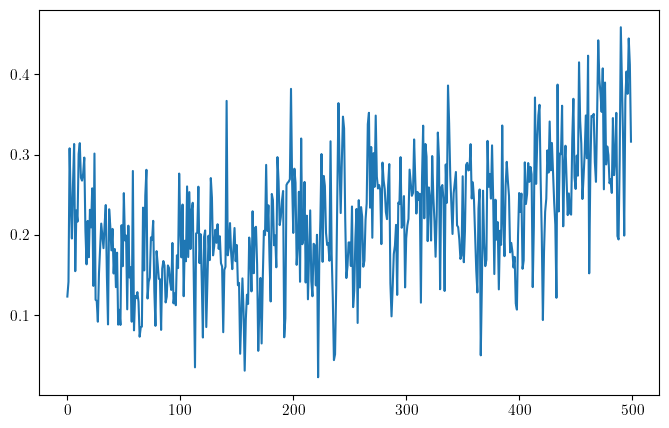

In [57]:
#Scatter plot of thinned acceptance probabilities - change policy_walk to return acceptance probabilities to use
print(np.average(acceptance_probs))
# plt.scatter(range(len(acceptance_probs[14::15])), acceptance_probs[14::15])
# plt.show()

# Moving average of acceptance probabilities
import math
window_size = 500
n_windows = math.floor(len(acceptance_probs)/window_size) 
averages = [] 
for i in range(n_windows): 
    averages.append(np.average(acceptance_probs[window_size*i:window_size*(i+1)]))
plt.plot(averages)
plt.show() 


Analysis of Average Learned Reward Matrix

In [4]:
import matplotlib.pyplot as plt 
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.size":    "11.0",
    "figure.figsize" : "8, 5",
    "axes.titlesize": "medium",
    "figure.titlesize": "medium"
})

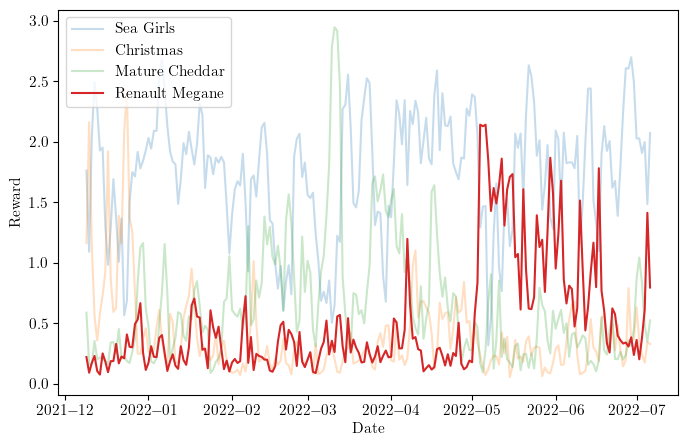

In [63]:
#Shows hte overall learned rewards - switch to the bigger colors array to view all 
colors = ["#e71d43","#ff0000","#ff3700","#ff6e00","#ffa500","#ffc300","#ffe100","#ffff00","#aad500","#55aa00","#008000","#005555","#002baa","#0000ff","#1900d5","#3200ac","#4b0082","#812ba6","#b857ca","#d03a87"]
avg_reward = np.average(np.asarray(learned_rewards[200000:]),axis = 0)
# print(observation_times)
s = 0
a = 0
T = 1
# colors = ["red", "orange","yellow","green","blue","indigo","violet"]
# for t in range(T):
#     label = "t = " + format(round(observation_times[t],2))
#     plt.plot(avg_reward[s,:,t], label = label)
# plt.ylabel("Reward")
# plt.xlabel("Action")
# plt.legend()
# plt.show()
actions = ['Sea Girls', 'Christmas', 'Mature Cheddar', 'Renault Megane']
import pandas as pd 
date_range = pd.date_range(start='2021-12-09', periods = len(observation_times), freq = 'D')
# date_range = pd.date_range(start='2021-12-09', end='2023-04-28', freq='D')
highlight = 3
for a in range(0,4):
    alpha = 0.25 
    if a == highlight:
        alpha = 1 
    plt.plot(date_range, avg_reward[s,a,:], label = actions[a], alpha = alpha)

plt.xlabel("Date")
plt.ylabel("Reward")
plt.legend()
plt.show()
# for t in range(T):
#     label = "t = " + format(round(observation_times[t],2))
#     plt.plot(R[s,:,t], color=colors[t*2], label = label)
# plt.ylabel("Reward")
# plt.xlabel("Action")
# plt.legend()
# plt.show()

Chain Analysis

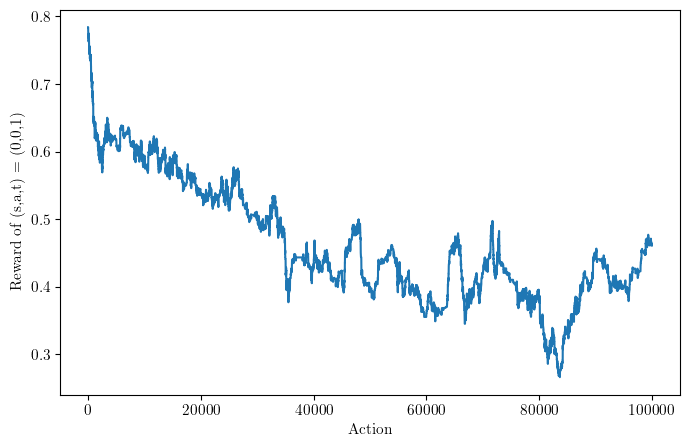

In [16]:
#Used to analyse individual chains: 
# print(observations)

#Plot a single reward
s,a,t = 0,0,1
plt.plot(learned_rewards[:,s,a,t])
ylabel = "Reward of (s,a,t) = (" + format(s) + "," + format(a) + "," + format(t) + ")"
plt.ylabel(ylabel)
plt.xlabel("Action")
plt.show()

c:\Users\tomms\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


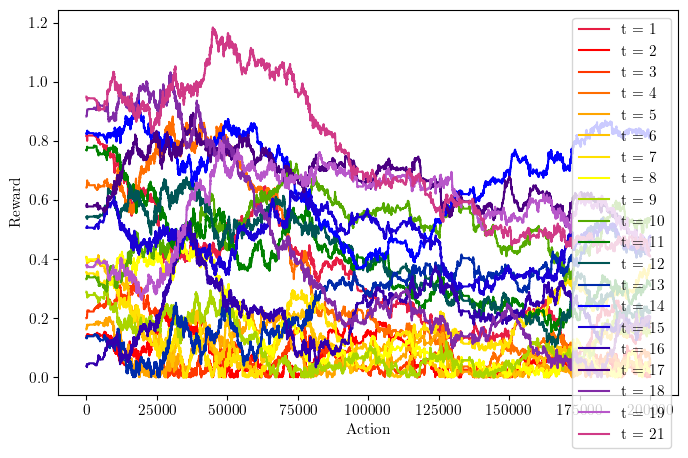

<Figure size 1600x1600 with 0 Axes>

In [50]:
#Plot rewards over time for a given state/action pair - shows observed (s,a,t) pairs in colour 
# print(observations)

#I could try plotting like true reward vs assigned reward over time or something to better visualise idk oh maybe do colours based on reward 
s,a, = 0,2
# s,t = 0,5
colors = ["#e71d43","#ff0000","#ff3700","#ff6e00","#ffa500","#ffc300","#ffe100","#ffff00","#aad500","#55aa00","#008000","#005555","#002baa","#0000ff","#1900d5","#3200ac","#4b0082","#812ba6","#b857ca","#d03a87"]
for t in range(20):
    label = "t = " + format(round(observation_times[t],1))# + " (" + format(round(R[s,a,t],1)) + ")"
    if [s,a,t] in observations: 
        plt.plot(learned_rewards[:,s,a,t], color=colors[t], label = label)
    else:
        plt.plot(learned_rewards[:,s,a,t], color="grey", label = label)        
    
plt.ylabel("Reward")
plt.xlabel("Iteration")
plt.legend()
plt.figure(figsize=(10,10), dpi=160)
plt.show()

Histogram Plots:

(112500, 20, 25)
[ 1.48342621  2.06145444  2.66023105  2.85876303  3.69473798  4.4269524
  5.01892834  6.73868046  8.50439363  9.64882156 10.79916827 12.29513518
 13.58271763 14.45882027 14.87027309 16.4749117  18.36470026 18.91622971
 20.22683265 20.42231037 21.18033258 22.46754857 23.42372582 24.21892929
 25.92169535]


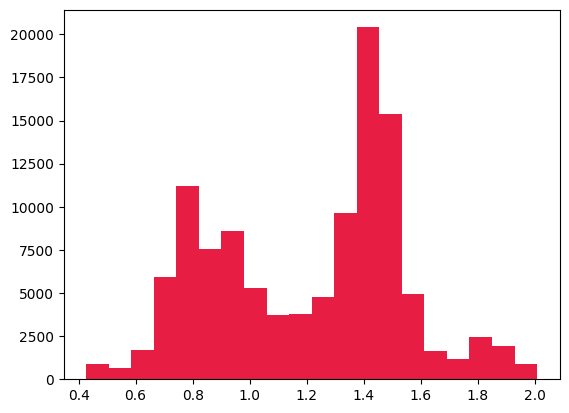

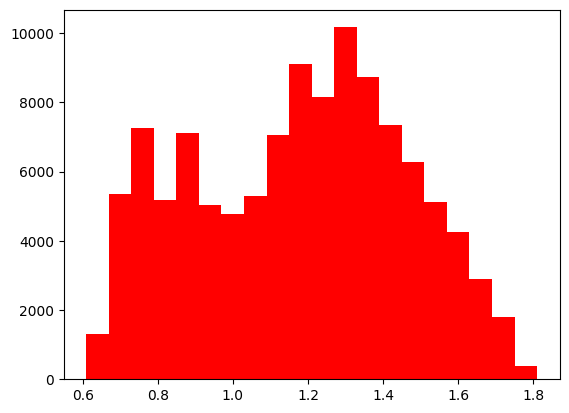

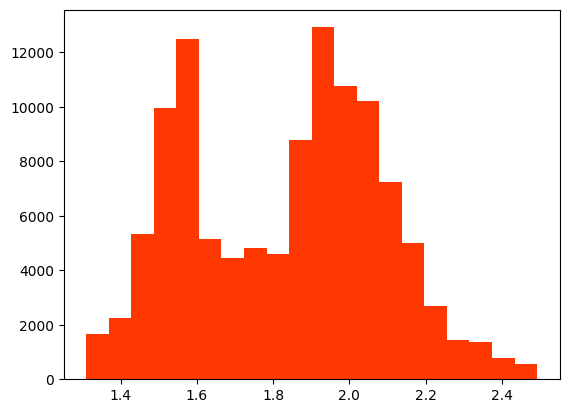

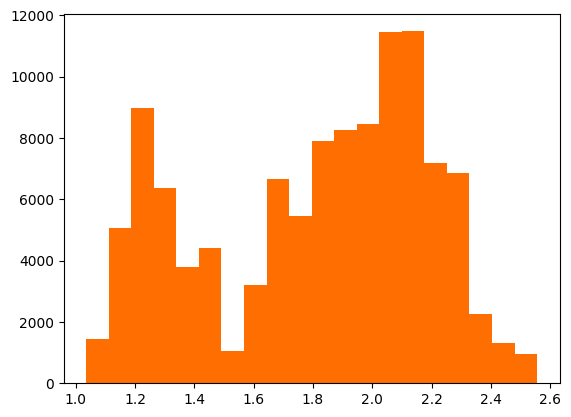

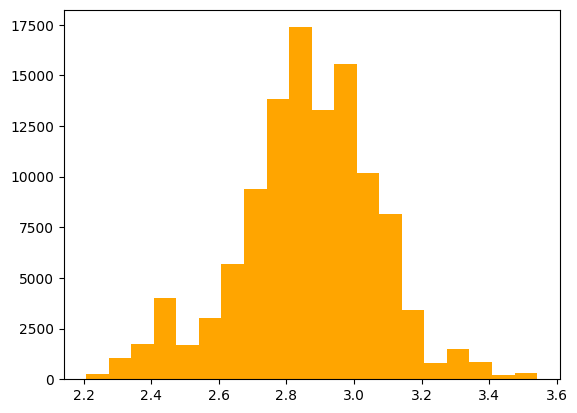

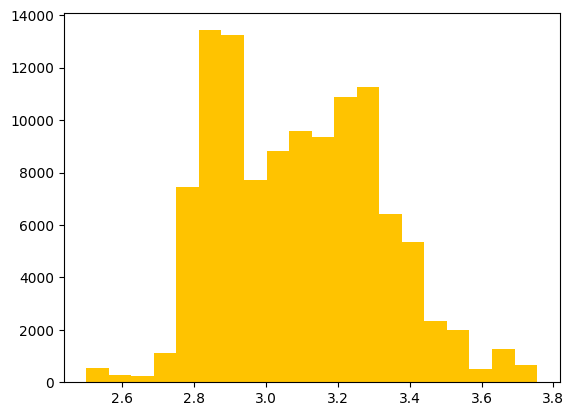

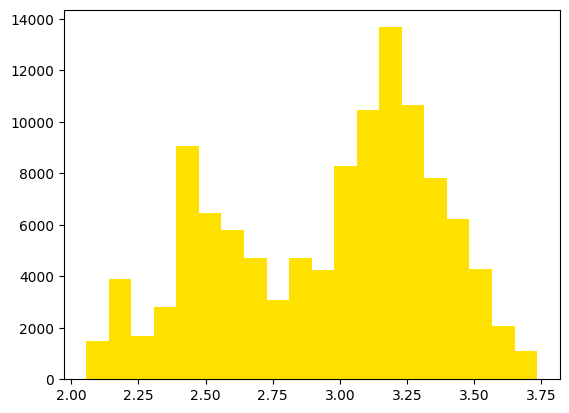

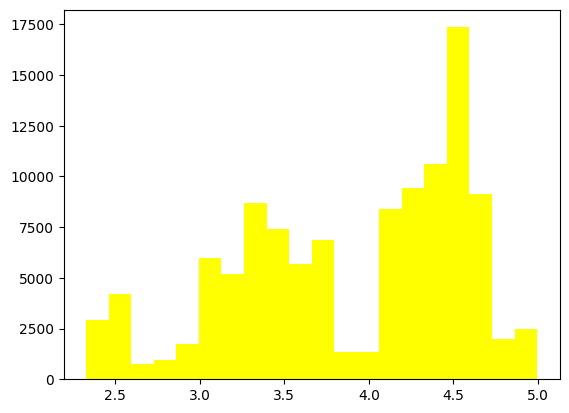

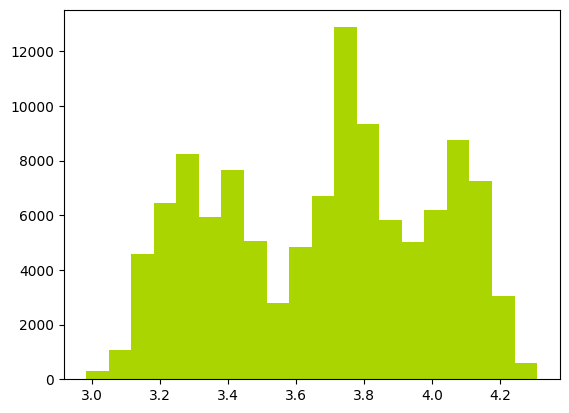

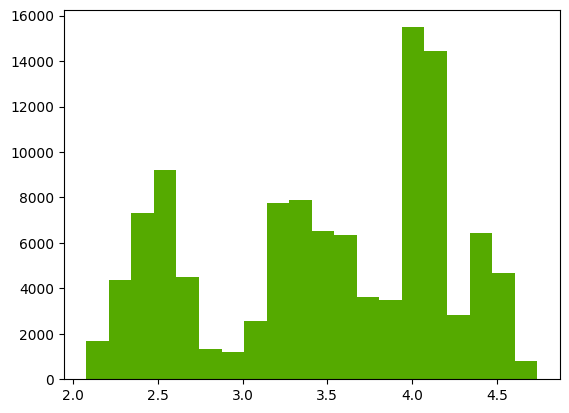

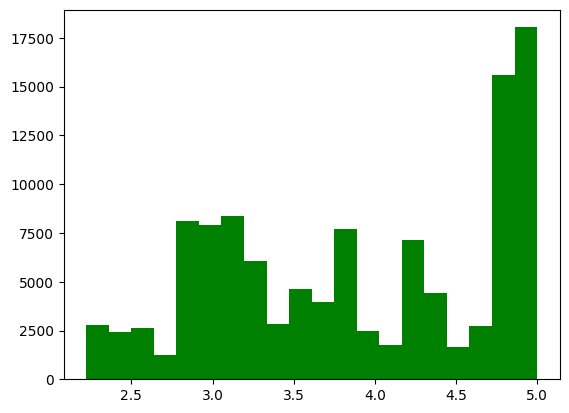

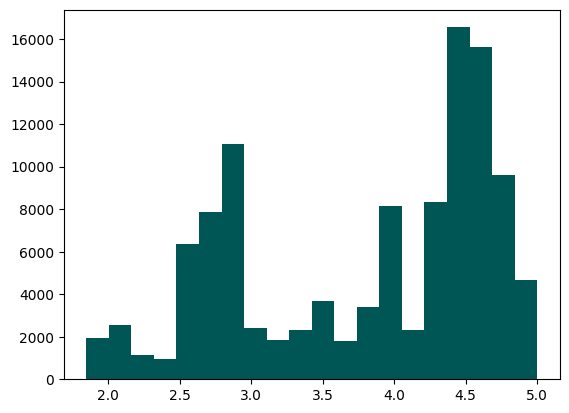

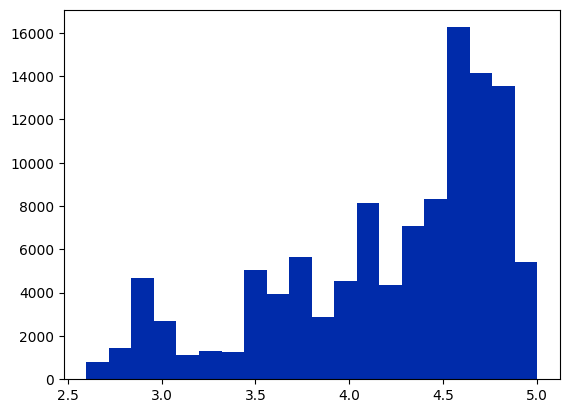

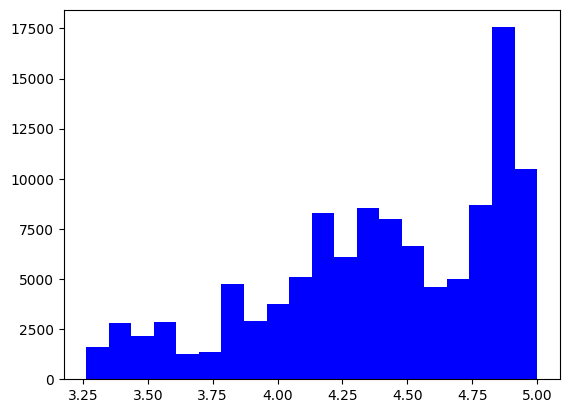

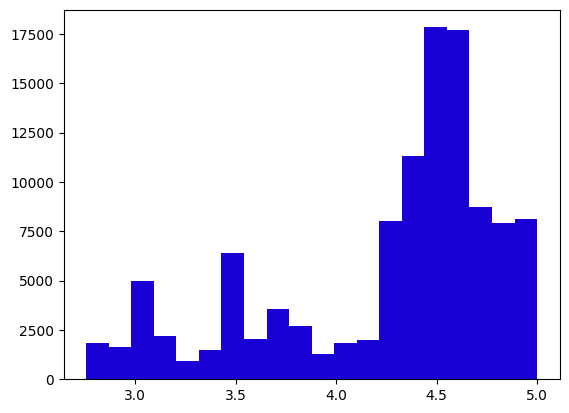

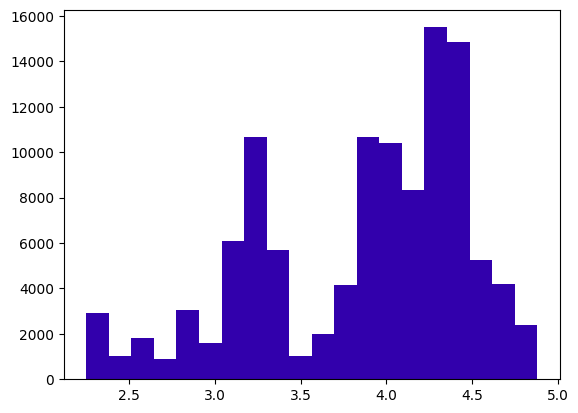

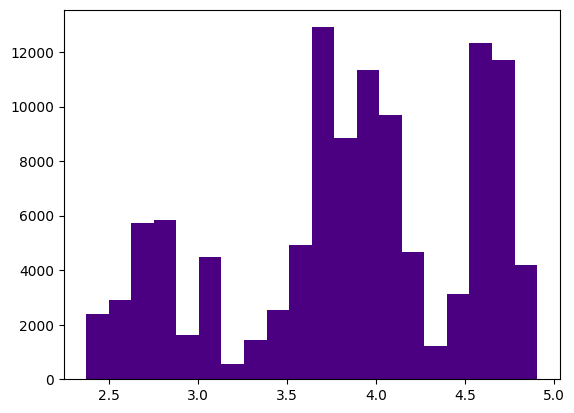

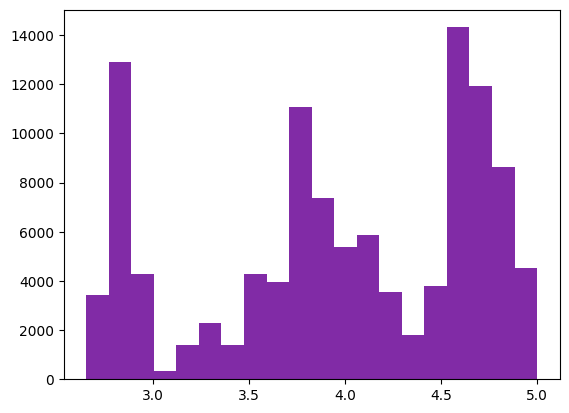

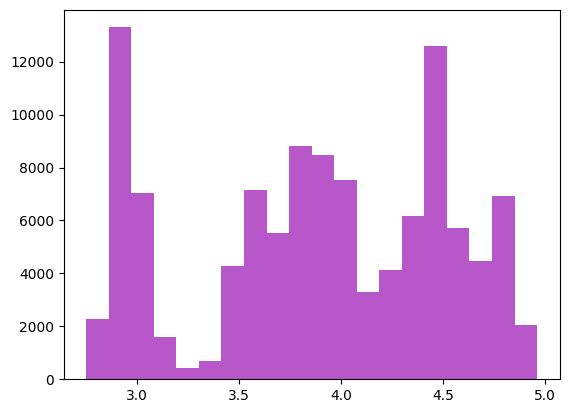

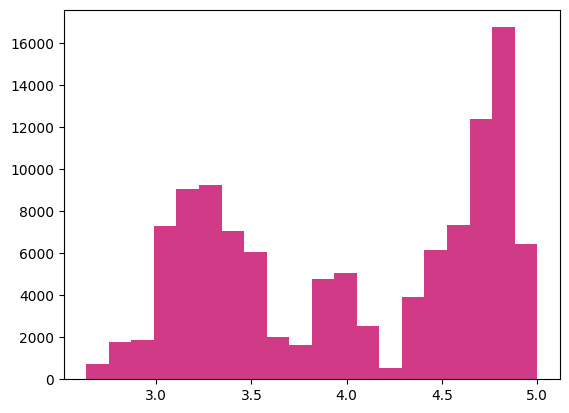

In [70]:
converged_rewards = learned_rewards[37500:]
np.swapaxes(converged_rewards,1,2)
converged_rewards = np.reshape(converged_rewards, (converged_rewards.shape[0], converged_rewards.shape[1]*converged_rewards.shape[2], converged_rewards.shape[3]))
print(converged_rewards.shape)
print(observation_times)
s,a,t = 0,2,0
for t in range(20): #so this should be like state 0 and any action, I kinda want any action that's not 0 but that's gonna be effortso this is kinda pointless actually lol I wanted to visualise it diminishing with time 
    #as greed decays 
    plt.hist(converged_rewards[:,s,t],bins = 20,color=colors[t])
    plt.show()